In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower() 
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) 
    text = re.sub(r'\@w+|\#','', text)  
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text) 
    text = re.sub(r'\d+', '', text) 
    text = text.strip()
    words = text.split()
    words = [word for word in words if word not in stop_words] 
    return ' '.join(words)
texts = data['tweet'].apply(preprocess)


In [2]:
url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv'
df = pd.read_csv(url)


In [3]:
df.shape

(24783, 7)

In [6]:
X = df['tweet'].astype(str)  
y = df['class']             



In [7]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

corpus = X.tolist()
vocab_size = 10000  
onehot_repr = [one_hot(sentence, vocab_size) for sentence in corpus]


sentence_length = 25  
X_padded = pad_sequences(onehot_repr, padding='pre', maxlen=sentence_length)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)


In [9]:
from tensorflow import keras

dimension = 50

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, dimension, input_length=sentence_length),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [10]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)


Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.7931 - loss: 0.6161 - val_accuracy: 0.8858 - val_loss: 0.3556
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9069 - loss: 0.2870 - val_accuracy: 0.8911 - val_loss: 0.3297
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.9228 - loss: 0.2321 - val_accuracy: 0.8741 - val_loss: 0.3859
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9448 - loss: 0.1657 - val_accuracy: 0.8820 - val_loss: 0.3841
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9613 - loss: 0.1232 - val_accuracy: 0.8844 - val_loss: 0.4275


In [17]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8832 - loss: 0.4348
Test Loss: 0.4275
Test Accuracy: 88.44%


In [18]:
def train_and_evaluate_model(embed_dim, lstm_units):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embed_dim, input_length=sentence_length),
        keras.layers.LSTM(lstm_units, return_sequences=True),
        keras.layers.LSTM(lstm_units),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=5, batch_size=64, verbose=0)

    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Embed Dim: {embed_dim}, LSTM Units: {lstm_units} --> Accuracy: {accuracy*100:.2f}%, Loss: {loss:.4f}")
    return accuracy, loss


In [19]:
results = []
for embed_dim in [50, 100]:
    for lstm_units in [64, 128]:
        acc, loss = train_and_evaluate_model(embed_dim, lstm_units)
        results.append((embed_dim, lstm_units, acc, loss))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Embed Dim: 50, LSTM Units: 64 --> Accuracy: 87.41%, Loss: 0.4688
Embed Dim: 50, LSTM Units: 128 --> Accuracy: 86.95%, Loss: 0.4737
Embed Dim: 100, LSTM Units: 64 --> Accuracy: 87.49%, Loss: 0.5009
Embed Dim: 100, LSTM Units: 128 --> Accuracy: 87.19%, Loss: 0.5490


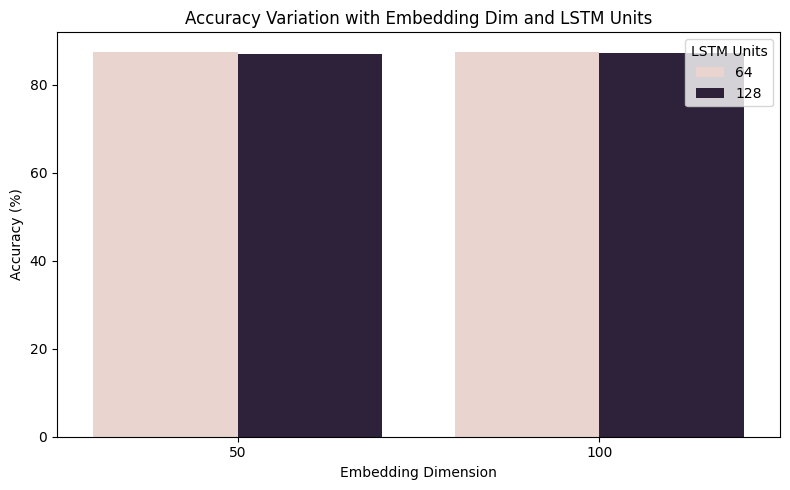

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.DataFrame(results, columns=["Embedding Dim", "LSTM Units", "Accuracy", "Loss"])
df_results["Accuracy (%)"] = df_results["Accuracy"] * 100

df_results

plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Embedding Dim", y="Accuracy (%)", hue="LSTM Units")
plt.title("Accuracy Variation with Embedding Dim and LSTM Units")
plt.ylabel("Accuracy (%)")
plt.xlabel("Embedding Dimension")
plt.tight_layout()
plt.show()


In [21]:
plt.savefig("accuracy_variation.png", dpi=300)


<Figure size 640x480 with 0 Axes>

155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


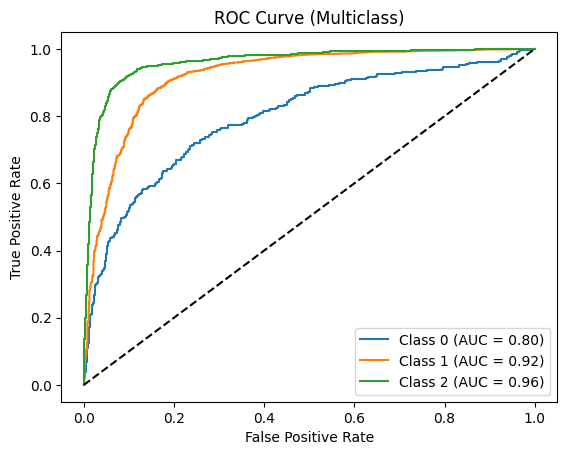

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

y_val_binarized = label_binarize(y_val, classes=[0, 1, 2])
y_pred_prob = model.predict(X_val)

for i in range(3):
    fpr, tpr, _ = roc_curve(y_val_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

 Hate Speech       0.45      0.21      0.29       290
   Offensive       0.92      0.95      0.93      3832
     Neither       0.81      0.81      0.81       835

    accuracy                           0.88      4957
   macro avg       0.72      0.66      0.68      4957
weighted avg       0.87      0.88      0.87      4957



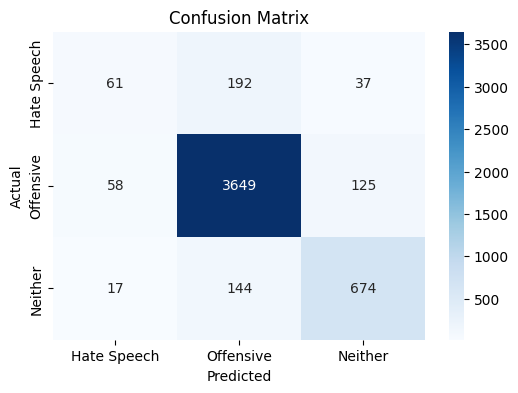

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_classes = np.argmax(model.predict(X_val), axis=1)

print(classification_report(y_val, y_pred_classes, target_names=['Hate Speech', 'Offensive', 'Neither']))

cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive', 'Neither'], yticklabels=['Hate Speech', 'Offensive', 'Neither'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [13]:
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9608
Final Validation Accuracy: 0.8844
Final Training Loss: 0.1248
Final Validation Loss: 0.4275


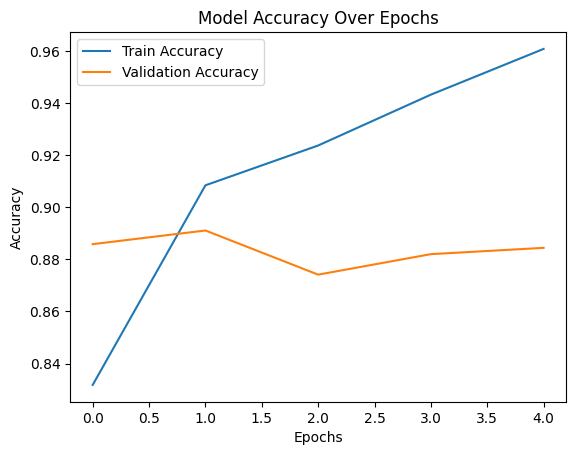

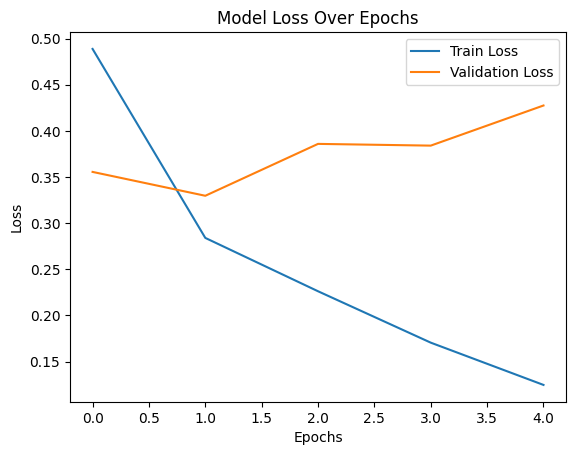

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8832 - loss: 0.4348
Test Loss: 0.4275
Test Accuracy: 88.44%
